# Hate Speech Detection

In [ ]:
pip install textstat

     |████████████████████████████████| 105 kB 5.2 MB/s 
     |████████████████████████████████| 2.0 MB 29.3 MB/s 


In [ ]:
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = panda.read_csv("/content/drive/MyDrive/hate-speech-data/HateSpeechData.csv")
dataset

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
# Adding text-length as a field in the dataset
dataset['text length'] = dataset['tweet'].apply(len)

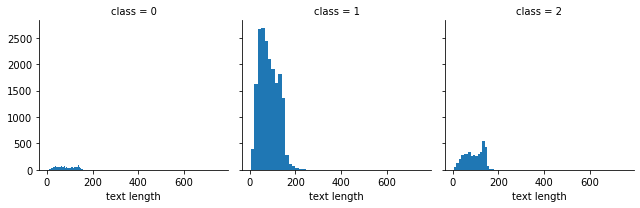

In [ ]:
#Basic visualization of data using histograms
# FacetGrid- Multi-plot grid for plotting conditional relationships
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=dataset, col='class')
graph.map(plt.hist, 'text length', bins=50)

- a.	Distribution of text-length almost seem to be similar across all three classes
- b.	Number of tweets seem to be skewed a lot higher towards the class-1


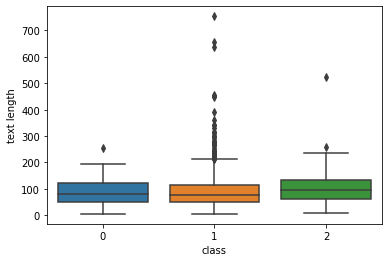

In [ ]:
# Box-plot visvualization
sns.boxplot(x='class', y='text length', data=dataset)

From the box-plot, looks like the class-1 tweets have much longer text. There are also outliers present so text-length won’t be a useful feature to consider.

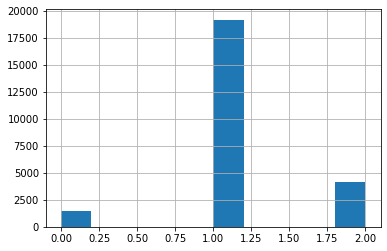

In [ ]:
dataset['class'].hist()

The above histogram shows that most of the tweets are considered to be offensive words by the CF coders.

In [ ]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet

## Preprocessing of the tweets

In [ ]:

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()


import os
from google.cloud import translate_v2 as translate
import pandas as pd

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"/content/drive/MyDrive/cloud_translation_key/GoogleCloudKey.json"
translate_client = translate.Client()

def translate(text,tag):
    return (translate_client.translate(text,tag)["translatedText"].replace("&#39;","\\\'"))

def f(text,src,trg):
    return (translate_client.translate(text, source_language=src,target_language=trg)["translatedText"].replace("&#39;","\\\'"))

def preprocess_text(text):
    if('a'<=text[0]<='z' or "A"<=text[0]<"Z"):
        return f(f(text,"en","hi"),"hi","en")

    return f(text,"hi","en")


def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')
    
    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets
# print(dataset[["tweet","processed_tweets"]].head(10))

## Visualizations

## Feature Engineering

In [ ]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )

tfidf

<24783x6441 sparse matrix of type '<class 'numpy.float64'>'
	with 189618 stored elements in Compressed Sparse Row format>

### Running various model Using TFIDF without additional features

In [ ]:
# If you don't specify the random_state in the code, 
# then every time you run(execute) your code a new random value is generated 
# and the train and test datasets would have different values each time.
X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

In [ ]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.48      0.16      0.23       290
           1       0.93      0.96      0.94      3832
           2       0.83      0.91      0.87       835

    accuracy                           0.90      4957
   macro avg       0.75      0.67      0.68      4957
weighted avg       0.89      0.90      0.89      4957

Random Forest, Accuracy Score: 0.9021585636473674


In [ ]:
support =LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc2)

              precision    recall  f1-score   support

           0       0.46      0.26      0.33       290
           1       0.92      0.95      0.94      3832
           2       0.83      0.85      0.84       835

    accuracy                           0.89      4957
   macro avg       0.74      0.69      0.70      4957
weighted avg       0.88      0.89      0.89      4957

SVM, Accuracy Score: 0.8932822271535202


In [ ]:

from tabulate import tabulate
input = ["shubh prahbhat please have a accha din","muslims ki hatya karo unko maaro", "ladkiyo ko equal pay nahi milna chahiye ","ईसाइयों को मंदिर में प्रवेश की अनुमति नहीं है "]

input_processed = input.copy()
for i in range(len(input)):
    input_processed[i] = preprocess_text(input[i])

# input_processed[-1] = preprocess_devenagri_text(input[-1])

mtfidf = tfidf_vectorizer.transform(input_processed)


svm_output = support.predict(mtfidf)
rf_output = rf.predict(mtfidf)
lr_output = model.predict(mtfidf)   

print(tabulate([[input[i],svm_output[i],rf_output[i],lr_output[i]] for i in range(len(svm_output))], headers=['Text', 'SVM',"RandomForestClassifier","Logistic Regression"]))


Text                                       SVM    RandomForestClassifier    Logistic Regression
---------------------------------------  -----  ------------------------  ---------------------
shubh prahbhat please have a accha din       2                         2                      2
muslims ki hatya karo unko maaro             0                         2                      0
ladkiyo ko equal pay nahi milna chahiye      1                         1                      1
ईसाइयों को मंदिर में प्रवेश की अनुमति नहीं है         1                         2                      1
